# Tutorial

DFTK is a Julia package for playing with plane-wave
density-functional theory algorithms. In its basic formulation it
solves periodic Kohn-Sham equations.

This document provides an overview of the structure of the code
and how to access basic information about calculations.
Basic familiarity with the concepts of plane-wave density functional theory
is assumed throughout.

!!! note "Convergence parameters in the documentation"
    We use very rough parameters in order to be able
    to generate these docs quickly. Therefore results are far from converged
    and tighter thresholds and larger grids should be used for more realistic results.

For our discussion we will use the classic example of
computing the LDA ground state of the silicon crystal.
Performing such a calculation roughly proceeds in three steps.

In [1]:
using DFTK

# 1. Define lattice and atomic positions
a = 10.26  # Silicon lattice constant in Bohr
lattice = a / 2 * [[0 1 1.];
                   [1 0 1.];
                   [1 1 0.]]

# Load HGH pseudopotential for Silicon
Si = ElementPsp(:Si, psp=load_psp("hgh/lda/Si-q4"))

# Specify type and positions of atoms
atoms = [Si => [ones(3)/8, -ones(3)/8]]

# 2. Select model and basis
model = model_LDA(lattice, atoms)
kgrid = [4, 4, 4]  # k-point grid (Regular Monkhorst-Pack grid)
Ecut = 7           # kinetic energy cutoff in Hartree
basis = PlaneWaveBasis(model, Ecut; kgrid=kgrid)

# 3. Run the SCF procedure to obtain the ground state
scfres = self_consistent_field(basis, tol=1e-8);

Iter   Energy             ρout-ρin
----   ------             --------
  1    -7.885158457616    1.928190E-01
  2    -7.901088757373    1.712046E-02
  3    -7.903241938312    5.886141E-03
  4    -7.903288544553    5.303197E-04
  5    -7.903289948014    1.035072E-04
  6    -7.903289964333    1.521533E-05
  7    -7.903289965076    2.095790E-06


DFTK by default applies the convergence tolerance `tol`
to the energy difference, so that the norm in the density difference
is not yet converged to 8 digits.

## Units in DFTK
For all quantities DFTK uses
[atomic units](https://en.wikipedia.org/wiki/Hartree_atomic_units),
where lengths are in Bohr, energies in Hartree and so on.
For conversion to other units, DFTK provides conversion factors
in the `DFTK.units` module.
The convention is that the conversion factors convert *into* atomic units,
therefore multiply to convert into the DFTK convention and divide
to convert to other units[^1]:

[^1]:
    To enter unicode characters like Å in the Julia REPL or a Jupyter notebook
    type their latex command (`\AA`) and press TAB. For common editors
    there are [Julia plugins](https://github.com/JuliaEditorSupport),
    which provide the same functionality.

In [2]:
import DFTK.units: eV, Å
10eV      # 10eV in Hartree

0.3674932248

In [3]:
1.2 / Å  # 1.2 Bohr in Ångström

0.635012652804

!!! warning "Differing unit conventions"
    Different electronic-structure codes use different unit conventions.
    For example for lattice vectors the common length units
    are bohr (used by DFTK) and Ångström (used e.g. by ASE, 1Å ≈ 1.80 bohr).
    When setting up a calculation for DFTK
    one needs to ensure to convert to bohr and atomic units.
    For some Python libraries (currently ASE, pymatgen and abipy)
    DFTK directly ships conversion tools in form of the `load_lattice`
    and `load_atoms` functions,
    which take care of such conversions. Examples, which demonstrate this
    are Creating slabs with ASE and Creating supercells with pymatgen.

Computations take place in the unit cell of a lattice defined by a ``3 × 3``
matrix (`model.lattice`) with lattice vectors as columns.
Denoting this matrix by ``A``, the corresponding reciprocal lattice,
that is the lattice of Fourier coefficients,
is defined by
$$
B = 2\pi A^{-T} = 2π {A^{T}}^{-1}
$$
and is available in DFTK as `model.recip_lattice`.
Consequently:

In [4]:
1/2π * model.recip_lattice' * model.lattice

3×3 StaticArrays.SArray{Tuple{3,3},Float64,2,9} with indices SOneTo(3)×SOneTo(3):
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

!!! warning "Row-major versus column-major storage order"
    Julia stores matrices as column-major, but other languages
    (notably Python and C) use row-major ordering.
    Care therefore needs to be taken to properly
    transpose the unit cell matrices ``A`` before using it with DFTK.
    For the supported third-party packages `load_lattice`
    and `load_atoms` again handle such conversion automatically.

A more detailed overview over the conventions used inside DFTK,
such as the coordinate systems used to express vectors in real or reciprocal space
or the typical symbols to denote key quantities in the code, see
Notation and conventions.

## `Model` datastructure
The physical model to be solved is defined by the `Model`
datastructure. It contains the unit cell, number of electrons, atoms,
type of spin polarization and temperature. Each atom has an atomic
type (`Element`) specifying the number of valence electrons and the
potential (or pseudopotential) it creates with respect to the electrons.
The `Model` structure also contains the list of energy terms
defining the energy functional to be minimised during the SCF.
For the silicon example above, we used
an LDA model, which consists of the following terms[^2]:

[^2]: If you are not familiar with Julia syntax, this is equivalent to `[typeof(t) for t in model.term_types]`.

In [5]:
typeof.(model.term_types)

7-element Array{DataType,1}:
 Kinetic       
 AtomicLocal   
 AtomicNonlocal
 Ewald         
 PspCorrection 
 Hartree       
 Xc            

DFTK computes energies for all terms of the model individually,
which are available in `scfres.energies`:

In [6]:
scfres.energies

Energy breakdown:
    Kinetic             3.1029840 
    AtomicLocal         -2.1959033
    AtomicNonlocal      1.7296329 
    Ewald               -8.4004648
    PspCorrection       -0.2948928
    Hartree             0.5523870 
    Xc                  -2.3970331

    total               -7.903289965076


For now the following energy terms are available in DFTK:

- Kinetic energy
- Local potential energy, either given by analytic potentials or
  specified by the type of atoms.
- Nonlocal potential energy, for norm-conserving pseudopotentials
- Nuclei energies (Ewald or pseudopotential correction)
- Hartree energy
- Exchange-correlation energy
- Power nonlinearities (useful for Gross-Pitaevskii type models)
- Magnetic field energy
- Entropy term

Custom types can be added if needed. For examples see
the definition of the above terms in the
[`src/terms`](https://dftk.org/tree/master/src/terms) directory.

By mixing and matching these terms, the user can create custom models
not limited to DFT. Convenience constructors are provided for common cases:

- `model_LDA`: LDA model using the
  [Teter parametrisation](https://doi.org/10.1103/PhysRevB.54.1703)
- `model_DFT`: Assemble a DFT model using
   any of the LDA or GGA functionals of the
   [libxc](https://tddft.org/programs/libxc/functionals/) library,
   for example:
   ```
   model_DFT(lattice, atoms, [:gga_x_pbe, :gga_c_pbe])
   model_DFT(lattice, atoms, :lda_xc_teter93)
   ```
   where the latter is equivalent to `model_LDA`.
   Specifying no functional is the reduced Hartree-Fock model:
   ```
   model_DFT(lattice, atoms, [])
   ```
- `model_atomic`: A linear model, which contains no electron-electron interaction
  (neither Hartree nor XC term).

## `PlaneWaveBasis` and plane-wave discretisations

The `PlaneWaveBasis` datastructure handles the discretization of a
given `Model` in a plane-wave basis.
In plane-wave methods the discretization is twofold:
Once the ``k``-point grid, which determines the sampling
*inside* the Brillouin zone and on top of that a finite
plane-wave grid to discretise the lattice-periodic functions.
The former aspect is controlled by the `kgrid` argument
of `PlaneWaveBasis`, the latter is controlled by the
cutoff energy parameter `Ecut`:

In [7]:
PlaneWaveBasis(model, Ecut; kgrid=kgrid)

PlaneWaveBasis (Ecut=7.0, 8 kpoints)

The `PlaneWaveBasis` by default uses symmetry to reduce the number of
`k`-points explicitly treated. For details see Crystal symmetries.

As mentioned, the periodic parts of Bloch waves are expanded
in a set of normalized plane waves ``e_G``:
$$
\begin{aligned}
  \psi_{k}(x) &= e^{i k \cdot x} u_{k}(x)\\
  &= \sum_{G \in \mathcal R^{*}} c_{G}  e^{i  k \cdot  x} e_{G}(x)
\end{aligned}
$$
where ``\mathcal R^*`` is the set of reciprocal lattice vectors.
The ``c_{{G}}`` are ``\ell^{2}``-normalized. The summation is truncated to a
"spherical", ``k``-dependent basis set
$$
  S_{k} = \left\{G \in \mathcal R^{*} \,\middle|\, \frac 1 2 |k+ G|^{2} \le E_\text{cut}\right\}
$$
where ``E_\text{cut}`` is the cutoff energy.

Densities involve terms like ``|\psi_{k}|^{2} = |u_{k}|^{2}`` and
therefore products ``e_{-{G}} e_{{G}'}`` for ``{G}, {G}'`` in
``S_{k}``. To represent these we use a "cubic", ``k``-independent
basis set large enough to contain the set
``\{{G}-G' \,|\, G, G' \in S_{k}\}``.
We can obtain the coefficients of densities on the
``e_{G}`` basis by a convolution, which can be performed efficiently
with FFTs (see `G_to_r` and `r_to_G` functions).
Potentials are discretized on this same set.

The normalization conventions used in the code is that quantities
stored in reciprocal space are coefficients in the ``e_{G}`` basis,
and quantities stored in real space use real physical values.
This means for instance that wavefunctions in the real space grid are
normalized as ``\frac{|\Omega|}{N} \sum_{r} |\psi(r)|^{2} = 1`` where
``N`` is the number of grid points.

For example let us check the normalization of the first eigenfunction
at the first ``k``-point in reciprocal space:

In [8]:
ψtest = scfres.ψ[1][:, 1]
sum(abs2.(ψtest))

0.9999999999999998

We now perform an IFFT to get ψ in real space. The ``k``-point has to be
passed because ψ is expressed on the ``k``-dependent basis.
Again the function is normalised:

In [9]:
ψreal = G_to_r(basis, basis.kpoints[1], ψtest)
sum(abs2.(ψreal)) * model.unit_cell_volume / prod(basis.fft_size)

0.9999999999999997

The list of ``k`` points of the basis can be obtained with `basis.kpoints`.

In [10]:
basis.kpoints

8-element Array{Kpoint,1}:
 Kpoint(:both, Rational{Int64}[0//1, 0//1, 0//1], [1, 2, 3, 4, 18, 19, 20, 21, 22, 23  …  7978, 7979, 7980, 7981, 7982, 7983, 7997, 7998, 7999, 8000], Dict(7581 => 211,7640 => 231,7218 => 186,7158 => 170,464 => 68,882 => 110,7203 => 185,7659 => 235,384 => 40,1261 => 136…), StaticArrays.SArray{Tuple{3},Int64,1,3}[[0, 0, 0], [1, 0, 0], [2, 0, 0], [3, 0, 0], [-3, 0, 0], [-2, 0, 0], [-1, 0, 0], [0, 1, 0], [1, 1, 0], [2, 1, 0]  …  [-3, -2, -1], [-2, -2, -1], [-1, -2, -1], [0, -1, -1], [1, -1, -1], [2, -1, -1], [-4, -1, -1], [-3, -1, -1], [-2, -1, -1], [-1, -1, -1]])   
 Kpoint(:both, Rational{Int64}[1//4, 0//1, 0//1], [1, 2, 3, 4, 18, 19, 20, 21, 22, 23  …  7978, 7979, 7980, 7981, 7982, 7983, 7997, 7998, 7999, 8000], Dict(7581 => 200,7640 => 217,7218 => 175,7158 => 159,464 => 63,882 => 103,7203 => 174,7659 => 221,1261 => 128,7157 => 158…), StaticArrays.SArray{Tuple{3},Int64,1,3}[[0, 0, 0], [1, 0, 0], [2, 0, 0], [3, 0, 0], [-3, 0, 0], [-2, 0, 0], [-1, 0, 0], [0, 1,

The ``G`` vectors of the "spherical", ``k``-dependent grid can be obtained
with `G_vectors`:

In [11]:
[length(G_vectors(kpoint)) for kpoint in basis.kpoints]

8-element Array{Int64,1}:
 259
 244
 242
 234
 238
 238
 230
 252

In [12]:
ik = 1
G_vectors(basis.kpoints[ik])[1:4]

4-element Array{StaticArrays.SArray{Tuple{3},Int64,1,3},1}:
 [0, 0, 0]
 [1, 0, 0]
 [2, 0, 0]
 [3, 0, 0]

The list of ``G`` vectors (Fourier modes) of the "cubic", ``k``-independent basis
set can be obtained similarly with `G_vectors(basis)`.

In [13]:
length(G_vectors(basis)), prod(basis.fft_size)

(8000, 8000)

In [14]:
collect(G_vectors(basis))[1:4]

4-element Array{StaticArrays.SArray{Tuple{3},Int64,1,3},1}:
 [0, 0, 0]
 [1, 0, 0]
 [2, 0, 0]
 [3, 0, 0]

Analogously the list of ``r`` vectors
(real-space grid) can be obtained with `r_vectors(basis)`:

In [15]:
length(r_vectors(basis))

8000

In [16]:
collect(r_vectors(basis))[1:4]

4-element Array{StaticArrays.SArray{Tuple{3},Float64,1,3},1}:
 [0.0, 0.0, 0.0] 
 [0.05, 0.0, 0.0]
 [0.1, 0.0, 0.0] 
 [0.15, 0.0, 0.0]

## Accessing Bloch waves and densities
Wavefunctions are stored in an array `scfres.ψ` as `ψ[ik][iG, iband]` where
`ik` is the index of the kpoint (in `basis.kpoints`), `iG` is the
index of the plane wave (in `G_vectors(basis.kpoints[ik])`) and
`iband` is the index of the band.
Densities are usually stored in a
special type, `RealFourierArray`, from which the representation in
real and reciprocal space can be accessed using `ρ.real` and
`ρ.fourier` respectively.

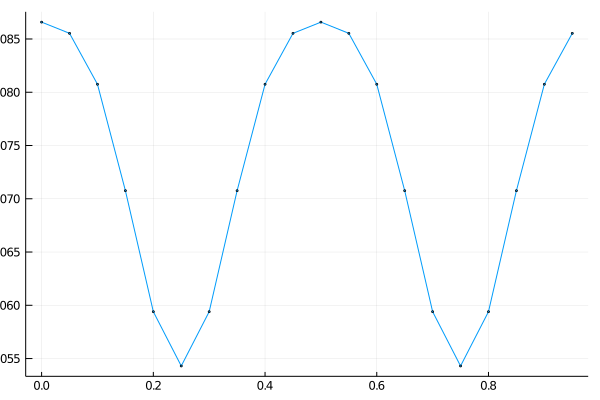

In [17]:
using Plots  # hide
rvecs = collect(r_vectors(basis))[:, 1, 1]  # slice along the x axis
x = [r[1] for r in rvecs]                   # only keep the x coordinate
plot(x, scfres.ρ.real[:, 1, 1], label="", xlabel="x", ylabel="ρ", marker=2)

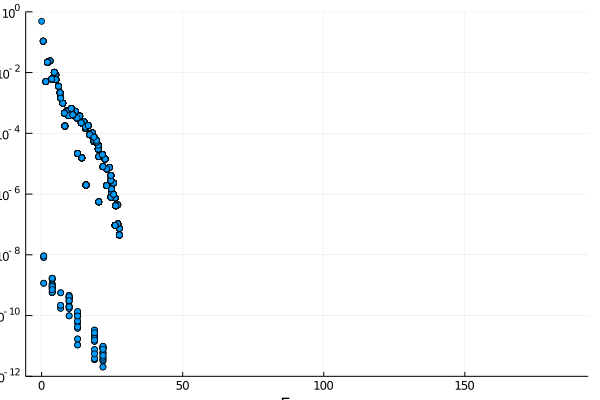

In [18]:
G_energies = [sum(abs2.(model.recip_lattice * G)) ./ 2 for G in G_vectors(basis)][:]
scatter(G_energies, abs.(scfres.ρ.fourier[:]);
        yscale=:log10, ylims=(1e-12, 1), label="", xlabel="Energy", ylabel="|ρ|^2")

Note that the density has no components on wavevectors above a certain energy,
because the wavefunctions are limited to ``\frac 1 2|k+G|^2 ≤ E_{\rm cut}``.

## Band structure calculations
Once an SCF solution has been computed, DFTK offers various
functions for post-processing, one being the plotting of a band structure:

Computing bands along kpath:
       Γ -> X -> W -> K -> Γ -> L -> U -> W -> L -> K  and  U -> X
Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:01


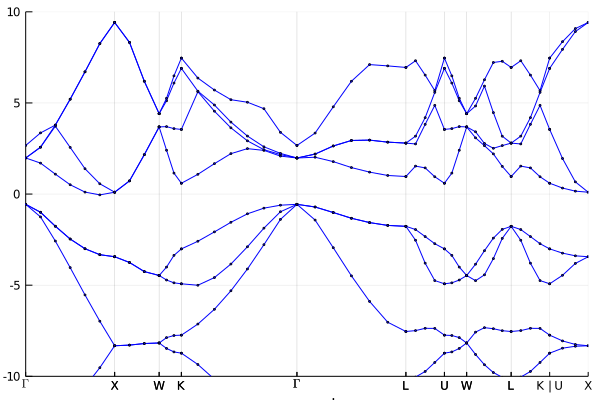

In [19]:
n_bands = 8
p = plot_bandstructure(scfres, n_bands, kline_density=5, unit=:eV)
p

    In this example we deliberately used an extremely small value
    for `kline_density` to speed up execution. In practice values
    of `10` or larger are recommended.
    The default value is `20` and provides pretty smooth bands.

## Where to go from here
Take a look at the
[example index](https://juliamolsim.github.io/DFTK.jl/dev/#example-index-1)
to continue exploring DFTK.